# Evaluation for Disease Ranking

The code below sets up tests for evaluating the rank_phenotypes python script to get the acccuracy of the ranking system. 

In [1]:
import rank_phenotypes
import random

2254 disease weights loaded!
6251 phenotype weights loaded!


In [2]:
import pandas as pd

In [3]:
def generate_patient(phen_dict):
    """
    Returns a list of the phenotypes the patient has.

    Parameters:
    phen_dict: A dictionary of the diseases phenotypes and corresponding prevalences
    """
    patient_phenotypes = []
    for key in phen_dict.keys():
        num = random.randint(1,100)
        if num/100 <= phen_dict[key]:
            patient_phenotypes.append(key)
    return patient_phenotypes

In [4]:
def test_ranks(trials, phen_dict, disease_id):
    """
    Runs rank_phenotypes for the given number of patients and disease dictionary
    Returns the accuracy of the results (Percentage of trials that gave the correct disease in the top five rankings)
    Parameters:
    trials: A int of the desired number of patient sets to run on
    phen_dict: dictionary of generated phenotypes
    disease_id: GARD of id of corresponding disease
    """
    successes = 0
    for trial in range(trials):
        phenos = generate_patient(phen_dict)
        rank_list = rank_phenotypes.rank_phenotypes_weighted_tfidf(phenos)
        top_ranks = []
        if len(rank_list) > 5:
            for entry in rank_list[:5]:
                top_ranks.append(entry[1]["id"])
        else:
            for entry in rank_list:
                top_ranks.append(entry[1]["id"])
        
        #just in results overall
        #for entry in rank_list:
            #top_ranks.append(entry[1]["id"])
        if disease_id in top_ranks: 
            successes += 1
        #print(top_ranks)
        #print("\n")
    return successes/trials

In [60]:
def get_rank(phen_dict, disease_id):
    """
    Runs rank_phenotypes for the given patient and disease dictionary
    Returns the ranking of the "correct" disease 
    Parameters:
    phen_dict: dictionary of generated phenotypes
    disease_id: GARD of id of corresponding disease
    """
    phenos = generate_patient(phen_dict)
    rank_list = rank_phenotypes.rank_phenotypes_weighted_tfidf(phenos)
    dz_ranks = []
    for entry in rank_list:
        dz_ranks.append(entry[1]["id"])
    if disease_id in dz_ranks: 
        rank = dz_ranks.index(disease_id) + 1
    else:
        rank = 1000
    return rank

In [15]:
#returns a corresponding phenotype:frequency dictionary for the selected prevalence rows from orphanet data
def get_dict(df):
    d = {}
    for index, row in df.iterrows():
        #uses renamed prevalence columns 
        hp_term = row["HPO_ID"]
        prevalence_str = row["Frequency"]
        if "Excluded" in prevalence_str:
            prev = 0.0
        elif "Obligate" in prevalence_str:
            prev = 1.0
        elif "Very rare" in prevalence_str:
            prev = 0.025
        elif "Occasional" in prevalence_str:
            prev = 0.17
        elif "Very frequent" in prevalence_str:
            prev = 0.895
        else:
            prev = 0.545
        d.update({hp_term:prev})
    return d

In [6]:
prevalences = pd.read_csv("phenotype_prevalences.csv")

In [9]:
prevalences = prevalences.rename(columns={"/DisorderList/Disorder/HPODisorderAssociationList/HPODisorderAssociation/HPO/HPOId": "HPO_ID", 
                            "/DisorderList/Disorder/HPODisorderAssociationList/HPODisorderAssociation/HPO/HPOTerm": "HP_Term",
                           "/DisorderList/Disorder/HPODisorderAssociationList/HPODisorderAssociation/HPOFrequency/Name": "Frequency",
                           "/DisorderList/Disorder/Name": "Disease_Name"})
prevalences.head()

,HPO_ID,HP_Term,Frequency,Disease_Name
0,HP:0000256,Macrocephaly,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"
1,HP:0000272,Malar flattening,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"
2,HP:0000316,Hypertelorism,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"
3,HP:0000369,Low-set ears,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"
4,HP:0000470,Short neck,Very frequent (99-80%),"Multiple epiphyseal dysplasia, Al-Gazali type"


In [10]:
prevalences.Frequency.unique()

array(['Very frequent (99-80%)', 'Frequent (79-30%)',
       'Occasional (29-5%)', 'Very rare (<4-1%)', 'Obligate (100%)',
       'Excluded (0%)'], dtype=object)

In [12]:
dz_list = prevalences.Disease_Name.unique()
dz_list

array(['Multiple epiphyseal dysplasia, Al-Gazali type',
       'Alexander disease', 'Alpha-mannosidosis', ..., 'Cleft velum',
       'Bifid uvula', 'Mosaic trisomy 9'], dtype=object)

In [44]:
from py2neo import Database
from py2neo import Graph
from py2neo import Node
db = Database("bolt://disease.ncats.io:80")
graph = db.default_graph

In [64]:
compiled_ranks = []
for dz in dz_list:
    #first see if there is a matching gard ID
    #get rid of the types (makes it less specific)
    dis_name = dz.upper()
    comma = dis_name.find(",")
    if comma != -1:
        dis_name = dis_name[:comma]
    q = """match (m:S_GARD)--(d:DATA) where any(x in m.N_Name where x =~ {dis_name}) RETURN d.gard_id"""
    d = graph.run(q, dis_name=dis_name).to_series()
    
    #if there is a matching gard ID, go through with the test
    if len(d) != 0:
        gard_id = d[:1][0]
        #get the matching rows
        rows = prevalences.loc[prevalences['Disease_Name'] == dz]
        #get phenotype dictionary from rows
        dz_dict = get_dict(rows)
        #run test (creates patient from dictionary, returns ranking, add to ranks)
        compiled_ranks.append(get_rank(dz_dict, gard_id))
        print(f"{dz} rank added!\n")
    else: 
        print("did not get gard match\n")

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000272', 'HP:0000316', 'HP:0000369', 'HP:0000470', 'HP:0000767', 'HP:0002007', 'HP:0002857', 'HP:0005930', 'HP:0006101', 'HP:0030084']
Multiple epiphyseal dysplasia, Al-Gazali type rank added!

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001250', 'HP:0001257', 'HP:0001274', 'HP:0001347', 'HP:0001355', 'HP:0001508', 'HP:0002007', 'HP:0002017', 'HP:0002167', 'HP:0002169', 'HP:0002353', 'HP:0002360', 'HP:0002650', 'HP:0007256', 'HP:0100729', 'HP:0000496', 'HP:0000508', 'HP:0000651', 'HP:0000712', 'HP:0000716', 'HP:0001251', 'HP:0001260', 'HP:0001288', 'HP:0001337', 'HP:0002019', 'HP:0002445', 'HP:0002615', 'HP:0010535', 'HP:0010628', 'HP:0002410', 'HP:0007481']
Alexander disease rank added!

ranking diseases for phenotypes
...['HP:0000158', 'HP:0000280', 'HP:0000365', 'HP:0000518', 'HP:0001249', 'HP:0001263', 'HP:0001744', 'HP:0002240', 'HP:0002652', 'HP:0002750', 'HP:0004493', 'HP:0005280', 'HP:0005978', 'HP:0007957', 'HP:

ranking diseases for phenotypes
...['HP:0000924', 'HP:0000980', 'HP:0001744', 'HP:0001903', 'HP:0001935', 'HP:0011902', 'HP:0000044', 'HP:0000929', 'HP:0001324', 'HP:0002240', 'HP:0004370']
Beta-thalassemia rank added!

ranking diseases for phenotypes
...['HP:0000952', 'HP:0001878', 'HP:0001903', 'HP:0001935', 'HP:0001971', 'HP:0002863', 'HP:0011902']
Alpha-thalassemia rank added!

ranking diseases for phenotypes
...['HP:0001738', 'HP:0002024', 'HP:0002205', 'HP:0002206', 'HP:0002240', 'HP:0002613', 'HP:0002721', 'HP:0004313']
Cystic fibrosis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000767', 'HP:0001315', 'HP:0001387', 'HP:0002486', 'HP:0003198', 'HP:0003236', 'HP:0006785', 'HP:0000912', 'HP:0001771', 'HP:0002515', 'HP:0003141', 'HP:0003306', 'HP:0003418', 'HP:0004631', 'HP:0008948', 'HP:0008956', 'HP:0008994', 'HP:0040083', 'HP:0003307']
Emery-Dreifuss muscular dystrophy rank added!

ranking diseases for phenotypes
...['HP:0000726', 'HP:0001324', '

ranking diseases for phenotypes
...['HP:0004870', 'HP:0001878', 'HP:0002719', 'HP:0012531', 'HP:0000939', 'HP:0001894', 'HP:0001923', 'HP:0002754', 'HP:0010885']
Sickle cell anemia rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0009919', 'HP:0000486', 'HP:0031615', 'HP:0000554', 'HP:0007862']
Retinoblastoma rank added!

ranking diseases for phenotypes
...['HP:0000818', 'HP:0000843', 'HP:0002897', 'HP:0003072', 'HP:0003165', 'HP:0008208', 'HP:0012091', 'HP:0000825', 'HP:0000845', 'HP:0000854', 'HP:0001012', 'HP:0001031', 'HP:0002574', 'HP:0006767', 'HP:0008256', 'HP:0012197', 'HP:0100634', 'HP:0010783']
Multiple endocrine neoplasia type 1 rank added!

ranking diseases for phenotypes
...['HP:0000053', 'HP:0000246', 'HP:0000275', 'HP:0000388', 'HP:0000389', 'HP:0000411', 'HP:0001388', 'HP:0001634', 'HP:0001763', 'HP:0002003', 'HP:0002020', 'HP:0002167', 'HP:0002342', 'HP:0003564', 'HP:0007018', 'HP:0100716']
Fragile X syndrome rank add

Hypophosphatasia rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001156', 'HP:0001249', 'HP:0001831', 'HP:0002644', 'HP:0002652', 'HP:0002758', 'HP:0002823', 'HP:0002970', 'HP:0002983', 'HP:0003307', 'HP:0003312', 'HP:0003416', 'HP:0009811', 'HP:0010535', 'HP:0011405']
Hypochondroplasia rank added!

ranking diseases for phenotypes
...['HP:0000268', 'HP:0000682', 'HP:0000684', 'HP:0000767', 'HP:0001363', 'HP:0001387', 'HP:0002650', 'HP:0004322', 'HP:0006487', 'HP:0100530', 'HP:0100777']
Hypophosphatemic rickets rank added!

ranking diseases for phenotypes
...['HP:0007763', 'HP:0000622', 'HP:0007924', 'HP:0200125', 'HP:0000576', 'HP:0000603', 'HP:0011675']
Leber hereditary optic neuropathy rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0002015', 'HP:0002653', 'HP:0002797', 'HP:0002893', 'HP:0004322', 'HP:0004936', 'HP:0005701', 'HP:0006824', 'HP:0007461', 'HP:0100021', 'HP:0100641']
Maffucci syndrome rank added!

ranking disease

did not get gard match

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000384', 'HP:0008572', 'HP:0008678', 'HP:0000402', 'HP:0000413', 'HP:0009796']
BOR syndrome rank added!

ranking diseases for phenotypes
...['HP:0000421', 'HP:0001081', 'HP:0001250', 'HP:0002092', 'HP:0001082', 'HP:0001342', 'HP:0001409', 'HP:0002040', 'HP:0002076', 'HP:0011025', 'HP:0100026', 'HP:0100585']
Hereditary hemorrhagic telangiectasia rank added!

ranking diseases for phenotypes
...['HP:0000294', 'HP:0000316', 'HP:0000324', 'HP:0000426', 'HP:0000929', 'HP:0001357', 'HP:0004209', 'HP:0000348', 'HP:0000444', 'HP:0001156', 'HP:0003307', 'HP:0005037', 'HP:0005280', 'HP:0006101', 'HP:0007598', 'HP:0008572', 'HP:0009899']
Saethre-Chotzen syndrome rank added!

ranking diseases for phenotypes
...['HP:0000262', 'HP:0000348', 'HP:0001156', 'HP:0004322', 'HP:0006101', 'HP:0009773', 'HP:0010669', 'HP:0011304']
Pfeiffer syndrome rank added!

ranking diseases for phenotypes
...['HP:0001003', 'HP:0005244', 'HP:00

ranking diseases for phenotypes
...['HP:0001319', 'HP:0003325', 'HP:0003327', 'HP:0003557', 'HP:0003722', 'HP:0003803', 'HP:0010628', 'HP:0030198', 'HP:0002970', 'HP:0003306']
Typical nemaline myopathy rank added!

ranking diseases for phenotypes
...['HP:0001638', 'HP:0001761', 'HP:0001989', 'HP:0003691', 'HP:0008180', 'HP:0030192', 'HP:0003198', 'HP:0003458', 'HP:0003798', 'HP:0002068', 'HP:0002312', 'HP:0002355', 'HP:0003306', 'HP:0003546', 'HP:0003557', 'HP:0003690', 'HP:0009055', 'HP:0000275', 'HP:0000276']
Childhood-onset nemaline myopathy rank added!

ranking diseases for phenotypes
...['HP:0000486', 'HP:0000639', 'HP:0000992', 'HP:0002227', 'HP:0005599', 'HP:0006739', 'HP:0007513', 'HP:0007730', 'HP:0007750', 'HP:0008499', 'HP:0011364']
Oculocutaneous albinism rank added!

ranking diseases for phenotypes
...['HP:0003198', 'HP:0003458', 'HP:0003798', 'HP:0002067', 'HP:0003326', 'HP:0003722', 'HP:0003803', 'HP:0000347', 'HP:0002747', 'HP:0011968']
Adult-onset nemaline myopathy ran

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000316', 'HP:0000431', 'HP:0001249', 'HP:0001252', 'HP:0001357', 'HP:0004209', 'HP:0100490', 'HP:0000347']
Pentasomy X rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000488', 'HP:0001257', 'HP:0001260', 'HP:0012675']
Neurodegeneration with brain iron accumulation rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000939', 'HP:0000952', 'HP:0001249', 'HP:0001252', 'HP:0001254', 'HP:0001263', 'HP:0001399', 'HP:0001510', 'HP:0001531', 'HP:0001541', 'HP:0001939', 'HP:0002017', 'HP:0008872', 'HP:0010741', 'HP:0100543', 'HP:0100806']
Galactosemia rank added!

ranking diseases for phenotypes
...['HP:0000298', 'HP:0001252', 'HP:0001288', 'HP:0002346', 'HP:0002650']
X-linked centronuclear myopathy rank added!

ranking diseases for phenotypes
...['HP:0001387', 'HP:0003457', 'HP:0004326', 'HP:0009073', 'HP:0100490', 'HP:0001319', 'HP:0001

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000046', 'HP:0000062', 'HP:0001265', 'HP:0001336', 'HP:0001510', 'HP:0001522', 'HP:0001695', 'HP:0002020', 'HP:0002459', 'HP:0002793', 'HP:0008736', 'HP:0010535', 'HP:0011675']
Sudden infant death-dysgenesis of the testes syndrome rank added!

ranking diseases for phenotypes
...['HP:0000160', 'HP:0000233', 'HP:0000316', 'HP:0000400', 'HP:0001156', 'HP:0001163', 'HP:0001171', 'HP:0001231', 'HP:0008388']
Charlie M syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000316', 'HP:0000494', 'HP:0000510', 'HP:0000648', 'HP:0000887', 'HP:0000944', 'HP:0002007', 'HP:0002750', 'HP:0003796', 'HP:0004322', 'HP:0005257', 'HP:0008905']
Axial spondylometaphyseal dysplasia rank added!

ranking diseases for phenotypes
...['HP:0000023', 'HP:0000325', 'HP:0000490', 'HP:0000505', 'HP:0000508', 'HP:0000512', 'HP:0000602', 'HP:0000648', 'HP:0000767', 'HP:0001387', 'HP:0001776', 'HP:0004097', 'HP:0010489', 'HP:0010751'

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001541', 'HP:0001789', 'HP:0001873', 'HP:0001903', 'HP:0010880']
Fetal parvovirus syndrome rank added!

ranking diseases for phenotypes
...['HP:0000407', 'HP:0000505', 'HP:0000508', 'HP:0000649', 'HP:0000708', 'HP:0000762', 'HP:0001263', 'HP:0002119', 'HP:0002194', 'HP:0002230', 'HP:0002514', 'HP:0003202', 'HP:0003236', 'HP:0003355', 'HP:0004322', 'HP:0004326', 'HP:0006887', 'HP:0012120']
Mitochondrial DNA depletion syndrome, encephalomyopathic form with methylmalonic aciduria rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0100022']
Dopa-responsive dystonia rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000272', 'HP:0000822', 'HP:0001083', 'HP:0001387', 'HP:0100543']
Isolated ectopia lentis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0011976']
Neuroblastoma rank added!

did not get gard match

ranking dise

ranking diseases for phenotypes
...['HP:0000175', 'HP:0001608', 'HP:0100335']
Congenital laryngomalacia rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000083', 'HP:0001161', 'HP:0001249', 'HP:0001513', 'HP:0006101', 'HP:0008736']
Laurence-Moon syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000750', 'HP:0001249', 'HP:0001188', 'HP:0001258', 'HP:0001288', 'HP:0001347', 'HP:0002381', 'HP:0004322', 'HP:0004374']
MASA syndrome rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000215', 'HP:0000248', 'HP:0000272', 'HP:0000327', 'HP:0000343', 'HP:0000407', 'HP:0000431', 'HP:0000463', 'HP:0000518', 'HP:0000545', 'HP:0000646', 'HP:0000655', 'HP:0002829', 'HP:0004322', 'HP:0004327', 'HP:0005280', 'HP:0010669', 'HP:0012368', 'HP:0000179', 'HP:0000316', 'HP:0000505', 'HP:0000520', 'HP:0000653', 'HP:0000966', 'HP:0001006', 'HP:0001083', 'HP:0002857', 'HP:0003196']
Marshall syndrome rank added!

ranking diseases for phenot

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000155', 'HP:0000613', 'HP:0000708', 'HP:0001269', 'HP:0001369', 'HP:0001482', 'HP:0002076', 'HP:0002105', 'HP:0002239', 'HP:0002829', 'HP:0003326', 'HP:0004936', 'HP:0011107', 'HP:0012378', 'HP:0100326', 'HP:0100653', 'HP:0001289', 'HP:0002017', 'HP:0002716', 'HP:0008066', 'HP:0100796', 'HP:0200034']
Behçet disease rank added!

ranking diseases for phenotypes
...['HP:0001252', 'HP:0001945', 'HP:0002039', 'HP:0002093', 'HP:0002633', 'HP:0002829', 'HP:0002960', 'HP:0003236', 'HP:0003457', 'HP:0003701', 'HP:0004303', 'HP:0006530', 'HP:0011675', 'HP:0012378', 'HP:0012544', 'HP:0012735']
Polymyositis rank added!

ranking diseases for phenotypes
...['HP:0000492', 'HP:0000934', 'HP:0000969', 'HP:0000989', 'HP:0001063', 'HP:0001369', 'HP:0001618', 'HP:0001824', 'HP:0002206', 'HP:0002664', 'HP:0002960', 'HP:0003326', 'HP:0003457', 'HP:0003701', 

ranking diseases for phenotypes
...['HP:0001824', 'HP:0001879', 'HP:0002092', 'HP:0002099', 'HP:0002110', 'HP:0002120', 'HP:0002715']
Allergic bronchopulmonary aspergillosis rank added!

ranking diseases for phenotypes
...['HP:0000478', 'HP:0000504', 'HP:0000651', 'HP:0000708', 'HP:0001257', 'HP:0001276', 'HP:0001608', 'HP:0002093', 'HP:0002205', 'HP:0002273', 'HP:0002425', 'HP:0002445', 'HP:0100021']
Locked-in syndrome rank added!

ranking diseases for phenotypes
...['HP:0001873', 'HP:0001945', 'HP:0002017', 'HP:0002027', 'HP:0002039', 'HP:0002152', 'HP:0002315', 'HP:0002615', 'HP:0008150', 'HP:0002098', 'HP:0002240', 'HP:0002716']
Leptospirosis rank added!

ranking diseases for phenotypes
...['HP:0000790', 'HP:0000988', 'HP:0001250', 'HP:0002017', 'HP:0002027', 'HP:0002039', 'HP:0002076', 'HP:0002383', 'HP:0002633', 'HP:0002829', 'HP:0003326', 'HP:0005244', 'HP:0010783', 'HP:0100534', 'HP:0100796', 'HP:0100820', 'HP:0200039']
Immunoglobulin A vasculitis rank added!

did not get gard 

ranking diseases for phenotypes
...['HP:0000822', 'HP:0000975', 'HP:0001482', 'HP:0001646', 'HP:0001654', 'HP:0001658', 'HP:0001824', 'HP:0001945', 'HP:0002039', 'HP:0002076', 'HP:0002617', 'HP:0002633', 'HP:0002637', 'HP:0002829', 'HP:0003326', 'HP:0004372', 'HP:0005111', 'HP:0005244', 'HP:0012378', 'HP:0100533', 'HP:0100545', 'HP:0100576', 'HP:0100735', 'HP:0100749', 'HP:0200042']
Takayasu arteritis rank added!

ranking diseases for phenotypes
...['HP:0012103', 'HP:0000091', 'HP:0000407', 'HP:0001250', 'HP:0001263', 'HP:0001508', 'HP:0002342']
EAST syndrome rank added!

ranking diseases for phenotypes
...['HP:0002097']
Congenital lobar emphysema rank added!

ranking diseases for phenotypes
...['HP:0000010', 'HP:0000112', 'HP:0000639', 'HP:0000648', 'HP:0000726', 'HP:0000819', 'HP:0000873', 'HP:0001250', 'HP:0001251', 'HP:0001260', 'HP:0001959', 'HP:0002093', 'HP:0002120', 'HP:0002871', 'HP:0008872', 'HP:0100016']
Wolfram syndrome rank added!

ranking diseases for phenotypes
...['HP:0

ranking diseases for phenotypes
...['HP:0003237', 'HP:0010702', 'HP:0002910', 'HP:0003262', 'HP:0003453', 'HP:0003493', 'HP:0030908', 'HP:0030909', 'HP:0012432', 'HP:0001394', 'HP:0003573']
Autoimmune hepatitis rank added!

ranking diseases for phenotypes
...['HP:0001278', 'HP:0001402', 'HP:0002841', 'HP:0003155', 'HP:0003493', 'HP:0003496', 'HP:0003073', 'HP:0000953', 'HP:0001394', 'HP:0002613', 'HP:0002908', 'HP:0011971', 'HP:0000820']
Primary biliary cholangitis rank added!

ranking diseases for phenotypes
...['HP:0000505', 'HP:0000716', 'HP:0000790', 'HP:0000975', 'HP:0001369', 'HP:0001387', 'HP:0001596', 'HP:0001824', 'HP:0001872', 'HP:0001945', 'HP:0002039', 'HP:0002315', 'HP:0002321', 'HP:0002633', 'HP:0003401', 'HP:0003565', 'HP:0005216', 'HP:0005244']
Giant cell arteritis rank added!

ranking diseases for phenotypes
...['HP:0000762', 'HP:0001284', 'HP:0002317', 'HP:0003474', 'HP:0003481', 'HP:0009830', 'HP:0010871', 'HP:0011096', 'HP:0012078', 'HP:0030200', 'HP:0002527']
Chron

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000347', 'HP:0001874', 'HP:0001888', 'HP:0002205', 'HP:0002721', 'HP:0003220', 'HP:0004313', 'HP:0004322', 'HP:0005280']
ICF syndrome rank added!

ranking diseases for phenotypes
...['HP:0000202', 'HP:0000238', 'HP:0000639', 'HP:0000657', 'HP:0001249', 'HP:0001250', 'HP:0001251', 'HP:0001252', 'HP:0001263', 'HP:0001288', 'HP:0001320', 'HP:0001696', 'HP:0002104', 'HP:0002793', 'HP:0002876', 'HP:0003312', 'HP:0004422']
Joubert syndrome rank added!

ranking diseases for phenotypes
...['HP:0000889', 'HP:0001171', 'HP:0001387', 'HP:0030680', 'HP:0001163', 'HP:0001199', 'HP:0001629', 'HP:0001631', 'HP:0002650', 'HP:0002808', 'HP:0006501', 'HP:0009777', 'HP:0011705']
Holt-Oram syndrome rank added!

ranking diseases for phenotypes
...['HP:0001056', 'HP:0002208', 'HP:0004782', 'HP:0000535', 'HP:0001482', 'HP:0008070', 'HP:0009886', 'HP:0000400']
Bazex-Dupré-Christol syn

did not get gard match

ranking diseases for phenotypes
...['HP:0000003', 'HP:0000047', 'HP:0000068', 'HP:0000089', 'HP:0000142', 'HP:0000218', 'HP:0000316', 'HP:0000370', 'HP:0000431', 'HP:0000528', 'HP:0000568', 'HP:0000618', 'HP:0000813', 'HP:0001126', 'HP:0001522', 'HP:0001602', 'HP:0001607', 'HP:0002025', 'HP:0003183', 'HP:0004397', 'HP:0006101', 'HP:0006610', 'HP:0007993', 'HP:0010297', 'HP:0010458']
Fraser syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000126', 'HP:0000162', 'HP:0000175', 'HP:0000201', 'HP:0000233', 'HP:0000252', 'HP:0000286', 'HP:0000343', 'HP:0000347', 'HP:0000463', 'HP:0000494', 'HP:0000508', 'HP:0000634', 'HP:0001156', 'HP:0001249', 'HP:0003202', 'HP:0004322', 'HP:0006824', 'HP:0010295']
Carey-Fineman-Ziter syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001644', 'HP:0001706', 'HP:0001874']
Barth syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000047', 'HP:0000164', 'HP:0000174', 'HP:0000252', 'HP:0000294', 'HP:0000311', 'HP:0000316', 'HP:0000319', 'HP:0000368', 'HP:0000400', 'HP:0000470', 'HP:0000486', 'HP:0000574', 'HP:0000670', 'HP:0001177', 'HP:0001252', 'HP:0002916', 'HP:0005280', 'HP:0006610', 'HP:0009738', 'HP:0010720', 'HP:0100490', 'HP:0100543']
Trisomy 4p rank added!

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000268', 'HP:0000311', 'HP:0000316', 'HP:0000411', 'HP:0000508', 'HP:0001163', 'HP:0001513', 'HP:0002007', 'HP:0002376', 'HP:0002916', 'HP:0004322', 'HP:0008678', 'HP:0008736']
Trisomy 5p rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000175', 'HP:0000190', 'HP:0000218', 'HP:0000232', 'HP:0000316', 'HP:0000347', 'HP:0000348', 'HP:0000411', 'HP:0000431', 'HP:0000470', 'HP:0000582', 'HP:0001263', 'HP:0001328', 'HP:0001387', 'HP:0002475', 'HP:0002916', 'HP:0008736', 'HP:0010751', 'H

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000112', 'HP:0000121', 'HP:0000212', 'HP:0000682', 'HP:0000684', 'HP:0000705', 'HP:0006286', 'HP:0011073', 'HP:0100530', 'HP:0000805', 'HP:0003127', 'HP:0012365']
Enamel-renal syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000348', 'HP:0000368', 'HP:0000444', 'HP:0000494', 'HP:0000958', 'HP:0001166', 'HP:0001249', 'HP:0001250', 'HP:0001252', 'HP:0001513', 'HP:0001631', 'HP:0001852', 'HP:0002007', 'HP:0002353', 'HP:0002857', 'HP:0002983', 'HP:0004322']
Beta-mercaptolactate cysteine disulfiduria rank added!

ranking diseases for phenotypes
...['HP:0001369', 'HP:0100727', 'HP:0200036']
Multicentric reticulohistiocytosis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000055', 'HP:0000389', 'HP:0000529', 'HP:0000532', 'HP:0000613', 'HP:0000842', 'HP:0000956', 'HP:0001249', 'HP:0001596', 'HP:0001644', 'HP:0001956', 'HP:0002092', 'HP:0

ranking diseases for phenotypes
...['HP:0000717', 'HP:0001249', 'HP:0001250', 'HP:0001263', 'HP:0001999', 'HP:0002007', 'HP:0002167', 'HP:0006951', 'HP:0007065']
X-linked intellectual disability-cerebellar hypoplasia syndrome rank added!

ranking diseases for phenotypes
...['HP:0000518', 'HP:0000639', 'HP:0000708', 'HP:0000750', 'HP:0001107', 'HP:0001249', 'HP:0007513', 'HP:0008046', 'HP:0001251', 'HP:0011364']
Autosomal recessive cerebelloparenchymal disorder type 3 rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000044', 'HP:0001251', 'HP:0007920']
Ataxia-hypogonadism-choroidal dystrophy syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000044', 'HP:0000135', 'HP:0000144', 'HP:0000512', 'HP:0000639', 'HP:0000648', 'HP:0000751', 'HP:0000771', 'HP:0000864', 'HP:0001251', 'HP:0002167', 'HP:0004322', 'HP:0004374', 'HP:0007703']
Cerebellar ataxia-hypogonadism syndrome rank added!

ranking diseases f

ranking diseases for phenotypes
...['HP:0000535', 'HP:0000653', 'HP:0000992', 'HP:0001249', 'HP:0002208', 'HP:0002299', 'HP:0003777', 'HP:0008070', 'HP:0010978', 'HP:0011362']
Hair defect-photosensitivity-intellectual disability syndrome rank added!

ranking diseases for phenotypes
...['HP:0001595', 'HP:0002208', 'HP:0002224', 'HP:0002552', 'HP:0011364']
Uncombable hair syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000154', 'HP:0000204', 'HP:0000248', 'HP:0000256', 'HP:0000286', 'HP:0000289', 'HP:0000316', 'HP:0000368', 'HP:0000445', 'HP:0000470', 'HP:0000486', 'HP:0000494', 'HP:0000574', 'HP:0000774', 'HP:0000892', 'HP:0000902', 'HP:0000912', 'HP:0001249', 'HP:0001320', 'HP:0002079', 'HP:0002119', 'HP:0002208', 'HP:0002937', 'HP:0003196', 'HP:0003422', 'HP:0011800', 'HP:0100790']
Cerebrofaciothoracic dysplasia rank added!

did not get gard match

did not get gard match

ranking diseases for phenot

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000478', 'HP:0000504', 'HP:0001251', 'HP:0001252', 'HP:0001263', 'HP:0001266', 'HP:0001284', 'HP:0001336', 'HP:0002069', 'HP:0002191', 'HP:0007359', 'HP:0100022']
Alpers-Huttenlocher syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000104', 'HP:0001510', 'HP:0001562', 'HP:0002089', 'HP:0012245', 'HP:0000776', 'HP:0000834', 'HP:0001629', 'HP:0001642', 'HP:0004794', 'HP:0005343', 'HP:0030680']
SERKAL syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000175', 'HP:0000322', 'HP:0000470', 'HP:0000494', 'HP:0000525', 'HP:0000568', 'HP:0000518', 'HP:0000708', 'HP:0001263', 'HP:0001188', 'HP:0001249', 'HP:0001250', 'HP:0001319', 'HP:0001510', 'HP:0001508', 'HP:0001770', 'HP:001

did not get gard match

ranking diseases for phenotypes
...['HP:0000413', 'HP:0002644', 'HP:0002823', 'HP:0002827', 'HP:0002983', 'HP:0004322', 'HP:0004349', 'HP:0008551']
Coxoauricular syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000154', 'HP:0000256', 'HP:0000280', 'HP:0000286', 'HP:0000294', 'HP:0000343', 'HP:0000463', 'HP:0000470', 'HP:0000527', 'HP:0000574', 'HP:0000885', 'HP:0000944', 'HP:0001256', 'HP:0001640', 'HP:0001654', 'HP:0002162', 'HP:0002230', 'HP:0002652', 'HP:0002673', 'HP:0002750', 'HP:0010109', 'HP:0012471']
Hypertrichotic osteochondrodysplasia, Cantu type rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000049', 'HP:0000218', 'HP:0000248', 'HP:0000252', 'HP:0000324', 'HP:0000349', 'HP:0000407', 'HP:0000431', 'HP:0000457', 'HP:0000494', 'HP:0000767', 'HP:0000889', 'HP:0000912', 'HP:0001156', 'HP:0001249', 'HP:0001252', 'HP:0001363', 'HP:0002007', 'HP:0002079', 'HP:0002162', 'HP:0002224', 'HP:0004

did not get gard match

ranking diseases for phenotypes
...['HP:0000077', 'HP:0000256', 'HP:0000260', 'HP:0000365', 'HP:0000520', 'HP:0000774', 'HP:0000926', 'HP:0000944', 'HP:0000946', 'HP:0001156', 'HP:0001171', 'HP:0001250', 'HP:0001252', 'HP:0001561', 'HP:0001582', 'HP:0001631', 'HP:0002093', 'HP:0002119', 'HP:0002187', 'HP:0002652', 'HP:0002808', 'HP:0002980', 'HP:0002983', 'HP:0003185', 'HP:0005280', 'HP:0006487', 'HP:0006703', 'HP:0007392', 'HP:0008909', 'HP:0012368', 'HP:0100781']
Thanatophoric dysplasia type 1 rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000119', 'HP:0000212', 'HP:0000518', 'HP:0000790', 'HP:0000962', 'HP:0001131', 'HP:0001596', 'HP:0002205', 'HP:0002213', 'HP:0002575', 'HP:0008070', 'HP:0012732']
Hereditary mucoepithelial dysplasia rank added!

ranking diseases for phenotypes
...['HP:0000787', 'HP:0000944', '

ranking diseases for phenotypes
...['HP:0001156', 'HP:0001162', 'HP:0001387', 'HP:0001522', 'HP:0001773', 'HP:0001831', 'HP:0002652', 'HP:0002983', 'HP:0005048', 'HP:0005736', 'HP:0006487', 'HP:0008368', 'HP:0008873', 'HP:0100242', 'HP:0100387']
Acromesomelic dysplasia, Grebe type rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000256', 'HP:0000348', 'HP:0000431', 'HP:0000776', 'HP:0001162', 'HP:0001770', 'HP:0001841', 'HP:0011304']
Greig cephalopolysyndactyly syndrome rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000248', 'HP:0000294', 'HP:0000316', 'HP:0000327', 'HP:0000483', 'HP:0000492', 'HP:0000504', 'HP:0000639', 'HP:0000647', 'HP:0000677', 'HP:0001163', 'HP:0001537', 'HP:0001643', 'HP:0001760', 'HP:0002208', 'HP:0002230', 'HP:0004322', 'HP:0004440', 'HP:0009882', 'HP:0010940']
Gorlin-Chaudhry-Moss syndrome rank added!

ranking diseases for phenotypes
...['HP:0001903', 'HP:0002716', 'HP:0002961']
Rosaï-Do

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0008751', 'HP:0000961', 'HP:0001615', 'HP:0010307', 'HP:0012735']
Laryngotracheoesophageal cleft rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001802', 'HP:0001810', 'HP:0008404']
Dominant dystrophic epidermolysis bullosa, nails only rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000534', 'HP:0000561', 'HP:0000958', 'HP:0000982', 'HP:0001006', 'HP:0001508', 'HP:0001596', 'HP:0001597', 'HP:0002224', 'HP:0002721', 'HP:0200037', 'HP:0200042']
Epidermolysis bullosa simplex due to plakophilin deficiency rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000464', 'HP:0000465', 'HP:0000478', 'HP:0000504']
Sternal cleft rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000047', 'HP:0000175', 'HP:0000204', 'HP:0000348', 'HP:0000369

did not get gard match

ranking diseases for phenotypes
...['HP:0001250', 'HP:0001252', 'HP:0001263', 'HP:0000365', 'HP:0002804', 'HP:0002240', 'HP:0003186', 'HP:0002120']
RFT1-CDG rank added!

ranking diseases for phenotypes
...['HP:0001873', 'HP:0002910', 'HP:0001878', 'HP:0000093', 'HP:0002315', 'HP:0004324', 'HP:0007430', 'HP:0011900', 'HP:0100602', 'HP:0001058', 'HP:0001937', 'HP:0410019']
HELLP syndrome rank added!

ranking diseases for phenotypes
...['HP:0000944', 'HP:0001028', 'HP:0001482', 'HP:0001928', 'HP:0002653', 'HP:0002763', 'HP:0002797', 'HP:0002983', 'HP:0005701', 'HP:0100761', 'HP:0100764']
Ollier disease rank added!

ranking diseases for phenotypes
...['HP:0000079', 'HP:0000126', 'HP:0001839', 'HP:0002414', 'HP:0012300', 'HP:0000368', 'HP:0000474', 'HP:0000954', 'HP:0002944', 'HP:0008593', 'HP:0009112', 'HP:0045026']
Czeizel-Losonci syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard m

ranking diseases for phenotypes
...['HP:0000982', 'HP:0001072', 'HP:0001231', 'HP:0001288', 'HP:0001761', 'HP:0003457', 'HP:0007021', 'HP:0008388', 'HP:0009830', 'HP:0010547']
Palmoplantar keratoderma-spastic paralysis syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000238', 'HP:0002017', 'HP:0002315', 'HP:0002354', 'HP:0002516', 'HP:0000492', 'HP:0000639', 'HP:0030531', 'HP:0100543', 'HP:0000364']
Pineocytoma rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0010799', 'HP:0002315', 'HP:0000708', 'HP:0002344', 'HP:0002516', 'HP:0100543', 'HP:0001250', 'HP:0007045']
Pineoblastoma rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for ph

ranking diseases for phenotypes
...['HP:0000298', 'HP:0001638', 'HP:0002015', 'HP:0003198', 'HP:0003390', 'HP:0003401', 'HP:0009830', 'HP:0010628', 'HP:0000479', 'HP:0001265', 'HP:0002059', 'HP:0002067', 'HP:0002345', 'HP:0002921', 'HP:0002936', 'HP:0003701', 'HP:0100295']
Autosomal recessive progressive external ophthalmoplegia rank added!

ranking diseases for phenotypes
...['HP:0003198', 'HP:0001324', 'HP:0002093', 'HP:0002333', 'HP:0001252', 'HP:0001270', 'HP:0001531', 'HP:0002098', 'HP:0003324', 'HP:0003546', 'HP:0003698', 'HP:0007105', 'HP:0008872', 'HP:0012432', 'HP:0000590']
Mitochondrial DNA depletion syndrome, myopathic form rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000275', 'HP:0000343', 'HP:0000407', 'HP:0000426', 'HP:0000456', 'HP:0000482', 'HP:0000518', 'HP:0000568', 'HP:0000677', 'HP:0000684', 'HP:0001634', 'HP:0001643', 'HP:0001671', 'HP:0002650', 'HP:0002967', 'HP:0004691', 'HP:0009778', 'HP:0011

ranking diseases for phenotypes
...['HP:0000962', 'HP:0007535', 'HP:0100725', 'HP:0200037', 'HP:0000498']
Lichen planus pemphigoides rank added!

ranking diseases for phenotypes
...['HP:0000268', 'HP:0000272', 'HP:0000275', 'HP:0000347', 'HP:0000358', 'HP:0000369', 'HP:0000405', 'HP:0000413', 'HP:0000494', 'HP:0000508', 'HP:0002435', 'HP:0002645', 'HP:0100775', 'HP:0000023', 'HP:0000470', 'HP:0001537', 'HP:0002162', 'HP:0002650', 'HP:0004452', 'HP:0004493', 'HP:0005487', 'HP:0000028', 'HP:0001263']
Lateral meningocele syndrome rank added!

ranking diseases for phenotypes
...['HP:0000939', 'HP:0000541', 'HP:0000938', 'HP:0001141', 'HP:0002515', 'HP:0003016', 'HP:0006957', 'HP:0007957', 'HP:0008947', 'HP:0012109', 'HP:0030490', 'HP:0003366']
Osteoporosis-pseudoglioma syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
..

did not get gard match

ranking diseases for phenotypes
...['HP:0001161', 'HP:0001249', 'HP:0001363', 'HP:0001680', 'HP:0002463', 'HP:0005692']
16p13.11 microduplication syndrome rank added!

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000047', 'HP:0000485', 'HP:0000492', 'HP:0001249', 'HP:0001257', 'HP:0001263', 'HP:0005517', 'HP:0008619', 'HP:0012374']
N syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001580', 'HP:0001003', 'HP:0000147', 'HP:0000845', 'HP:0001007', 'HP:0001034', 'HP:0002893', 'HP:0008225', 'HP:0008675', 'HP:0009588', 'HP:0011672', 'HP:0040086', 'HP:0100008', 'HP:0002297', 'HP:0002331', 'HP:0002640', 'HP:0010619']
Carney complex rank added!

ranking diseases for phenotypes
...['HP:0003326', 'HP:0003394', 'HP:0003458', 'HP:0003473', 'HP:0030200', 'HP:0100301']
Tubular aggregate myopathy rank added!

ranking diseases for phenotypes
...['HP:0001288', 'HP:0002123', 'HP:0002167', 'HP:0002353', 'HP:0003457', 'HP:0008955']
Sp

did not get gard match

ranking diseases for phenotypes
...['HP:0012358', 'HP:0000252', 'HP:0000639', 'HP:0001263', 'HP:0001344', 'HP:0001347', 'HP:0001394', 'HP:0001433', 'HP:0001873', 'HP:0003155', 'HP:0003256', 'HP:0008935', 'HP:0011172', 'HP:0012301']
COG4-CDG rank added!

ranking diseases for phenotypes
...['HP:0000201', 'HP:0000219', 'HP:0000319', 'HP:0000368', 'HP:0000470', 'HP:0000938', 'HP:0001103', 'HP:0001320', 'HP:0001508', 'HP:0001999', 'HP:0003026', 'HP:0003316', 'HP:0004582', 'HP:0008897', 'HP:0011995', 'HP:0030282', 'HP:0000253', 'HP:0003422']
COG1-CDG rank added!

ranking diseases for phenotypes
...['HP:0012363', 'HP:0001324', 'HP:0001644', 'HP:0002401', 'HP:0002910', 'HP:0003487', 'HP:0003749', 'HP:0003805', 'HP:0008331', 'HP:0008981']
DPM3-CDG rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000750', 'HP:0001270', 'HP:0008947', 'HP:0000252', 'HP:0004322', 'HP:0000470', 'HP:0001348', 'HP:0001433', 'HP:0002342', 'HP:0002506', 'HP:0009473', 

did not get gard match

ranking diseases for phenotypes
...['HP:0002211', 'HP:0005599', 'HP:0007544', 'HP:0000343', 'HP:0001249', 'HP:0002251']
Piebaldism rank added!

ranking diseases for phenotypes
...['HP:0000151', 'HP:0000347', 'HP:0000411', 'HP:0000470', 'HP:0001180', 'HP:0001511', 'HP:0001849', 'HP:0002164', 'HP:0002705', 'HP:0002983', 'HP:0002984', 'HP:0002990', 'HP:0002992', 'HP:0003498', 'HP:0006487', 'HP:0008517', 'HP:0008736', 'HP:0100257']
Phocomelia, Schinzel type rank added!

ranking diseases for phenotypes
...['HP:0000343', 'HP:0000402', 'HP:0000405', 'HP:0002002', 'HP:0003019', 'HP:0003031', 'HP:0004059', 'HP:0005105', 'HP:0005288', 'HP:0005792', 'HP:0006420', 'HP:0008551', 'HP:0009601', 'HP:0009813', 'HP:0009896', 'HP:0009906', 'HP:0011675', 'HP:0100257']
Phocomelia-ectrodactyly-deafness-sinus arrhythmia syndrome rank added!

ranking diseases for phenotypes
...['HP:0007099', 'HP:0002315', 'HP:0002331', 'HP:0030833', 'HP:0040010', 'HP:0001293', 'HP:0001605', 'HP:0002196

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000054', 'HP:0000121', 'HP:0000175', 'HP:0000193', 'HP:0000233', 'HP:0000252', 'HP:0000405', 'HP:0000483', 'HP:0000582', 'HP:0000592', 'HP:0000954', 'HP:0001100', 'HP:0001274', 'HP:0001864', 'HP:0002101', 'HP:0002162', 'HP:0002788', 'HP:0002828', 'HP:0003196', 'HP:0004209', 'HP:0005495', 'HP:0006801', 'HP:0009913', 'HP:0010034', 'HP:0010864', 'HP:0010945', 'HP:0012758', 'HP:0040018', 'HP:0001305', 'HP:0100790']
Trisomy 8p rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0007519', 'HP:0009751', 'HP:0010311', 'HP:0200055', 'HP:0000076', 'HP:0000081', 'HP:0000356', 'HP:0000768', 'HP:0000772', 'HP:0000773', 'HP:0002084', 'HP:0002162', 'HP:0006501', 'HP:0009601', 'HP:0010579']
Poland syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001162', 'HP:0002187', 'HP:0000303', 'HP:00013

Wiedemann-Rautenstrauch syndrome rank added!

ranking diseases for phenotypes
...['HP:0000161', 'HP:0000202', 'HP:0000252', 'HP:0000303', 'HP:0000505', 'HP:0000568', 'HP:0001199', 'HP:0001249', 'HP:0001629', 'HP:0001839']
MMEP syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000470', 'HP:0000473', 'HP:0001435', 'HP:0003043', 'HP:0008952']
Sprengel deformity rank added!

ranking diseases for phenotypes
...['HP:0003236', 'HP:0030099', 'HP:0002317', 'HP:0003551', 'HP:0008981', 'HP:0010864', 'HP:0003391']
Alpha-dystroglycan-related  limb-girdle muscular dystrophy R16 rank added!

ranking diseases for phenotypes
...['HP:0000613', 'HP:0000670', 'HP:0000682', 'HP:0000982', 'HP:0001072', 'HP:0001131', 'HP:0001156', 'HP:0001817', 'HP:0003510', 'HP:0004279', 'HP:0000230', 'HP:0001163', 'HP:0001231', 'HP:0010783', 'HP:0012047']
Corneodermatoosseous syndrome rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001251', 'HP:0001276', 'H

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000252', 'HP:0000426', 'HP:0000430', 'HP:0000431', 'HP:0000445', 'HP:0001249', 'HP:0001263', 'HP:0001328', 'HP:0002300', 'HP:0002357', 'HP:0003510', 'HP:0004209', 'HP:0010529', 'HP:0000494', 'HP:0000648', 'HP:0001252', 'HP:0001257', 'HP:0001376', 'HP:0001510', 'HP:0001511', 'HP:0001792', 'HP:0007598', 'HP:0010624', 'HP:0010761', 'HP:0001629']
Filippi syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000046', 'HP:0000135', 'HP:0000164', 'HP:0000204', 'HP:0000347', 'HP:0000400', 'HP:0000411', 'HP:0000670', 'HP:0000968', 'HP:0000972', 'HP:0001249', 'HP:0001596', 'HP:0001770', 'HP:0001810', 'HP:0002553', 'HP:0002744', 'HP:0003777', 'HP:0005338', 'HP:0006101', 'HP:0006482', 'HP:0006610', 'HP:0007598', 'HP:0008404', 'HP:0010669', 'HP:0100840']
Zlotogora-Ogur syndrome rank added!

did not get gard match

ranking diseases for phenot

did not get gard match

ranking diseases for phenotypes
...['HP:0000252', 'HP:0000316', 'HP:0000347', 'HP:0000431', 'HP:0000494', 'HP:0001249', 'HP:0001252', 'HP:0001347', 'HP:0002007', 'HP:0002119', 'HP:0002120', 'HP:0004322', 'HP:0007360', 'HP:0007370', 'HP:0012430']
White matter hypoplasia-corpus callosum agenesis-intellectual disability syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000248', 'HP:0001357', 'HP:0001558', 'HP:0002342', 'HP:0007000', 'HP:0010864']
X-linked intellectual disability-plagiocephaly syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001362', 'HP:0004471', 'HP:0007383', 'HP:0010301', 'HP:0001770', 'HP:0003010']
Aplasia cutis congenita rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

d

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001627', 'HP:0001629', 'HP:0001635', 'HP:0001651', 'HP:0001680', 'HP:0002089', 'HP:0004971', 'HP:0030680', 'HP:0001719', 'HP:0010773', 'HP:0011560', 'HP:0100790']
Scimitar syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000248', 'HP:0000388', 'HP:0000389', 'HP:0000979', 'HP:0001392', 'HP:0001744', 'HP:0001888', 'HP:0001973', 'HP:0002090', 'HP:0002110', 'HP:0002716', 'HP:0002721', 'HP:0002837', 'HP:0002910', 'HP:0004313', 'HP:0100723']
Common variable immunodeficiency rank added!

ranking diseases for phenotypes
...['HP:0001744', 'HP:0002716', 'HP:0002730', 'HP:0002960', 'HP:0000978', 'HP:0001890', 'HP:0001892', 'HP:0001904', 'HP:0001971', 'HP:0003237', 'HP:0010702', 'HP:0030782', 'HP:0000099', 'HP:0002848', 'HP:0003613', 'HP:0012115', 'HP:0030080', 'HP:0031020']
Autoimmune lymphoproliferative syndrome rank added!

ranking diseases for p

ranking diseases for phenotypes
...['HP:0001009', 'HP:0004952', 'HP:0002140', 'HP:0002326', 'HP:0000421', 'HP:0000961', 'HP:0002105', 'HP:0040223']
Pulmonary arteriovenous malformation rank added!

ranking diseases for phenotypes
...['HP:0008357', 'HP:0030657', 'HP:0000978', 'HP:0001342', 'HP:0001933', 'HP:0012233', 'HP:0000132', 'HP:0000225', 'HP:0001058', 'HP:0001934', 'HP:0031364', 'HP:0200067']
Congenital factor XIII deficiency rank added!

ranking diseases for phenotypes
...['HP:0000737', 'HP:0001254', 'HP:0001263', 'HP:0001298', 'HP:0001638', 'HP:0001985', 'HP:0002093', 'HP:0002240', 'HP:0002615', 'HP:0002910', 'HP:0003162', 'HP:0003201', 'HP:0003215', 'HP:0003234', 'HP:0004756', 'HP:0008331', 'HP:0011675', 'HP:0040290', 'HP:0045045']
Carnitine-acylcarnitine translocase deficiency rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000054', 'HP:0000519', 'HP:0000568', 'HP:0000961', 'HP:0000978', 'HP:0001649', 'HP:0001667', 'HP:0001712', 'HP:0001892', 'HP

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000093', 'HP:0000097', 'HP:0000117', 'HP:0000787', 'HP:0000790', 'HP:0001252', 'HP:0002027', 'HP:0002150', 'HP:0002653', 'HP:0002757', 'HP:0003355', 'HP:0003236', 'HP:0010580', 'HP:0003076', 'HP:0003109', 'HP:0003126', 'HP:0003149', 'HP:0003152', 'HP:0005576', 'HP:0005574', 'HP:0008732']
Dent disease rank added!

ranking diseases for phenotypes
...['HP:0009806', 'HP:0003228', 'HP:0004906', 'HP:0001945', 'HP:0002019', 'HP:0002039', 'HP:0001250']
Nephrogenic diabetes insipidus rank added!

ranking diseases for phenotypes
...['HP:0000822', 'HP:0001324', 'HP:0002153']
Pseudohypoaldosteronism type 2 rank added!

ranking diseases for phenotypes
...['HP:0005547', 'HP:0001744', 'HP:0001945', 'HP:0001974', 'HP:0012378']
Chronic myeloid leukemia rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0012379', 'HP:0002878']
Butyrylcholinesterase deficiency rank added!

did not get gard match

did not get gard match

did 

did not get gard match

ranking diseases for phenotypes
...['HP:0000938', 'HP:0000939', 'HP:0000963', 'HP:0000974', 'HP:0001252', 'HP:0001367', 'HP:0001373', 'HP:0001385', 'HP:0001387', 'HP:0002036', 'HP:0002300', 'HP:0002357', 'HP:0002381', 'HP:0002673', 'HP:0002748', 'HP:0002749', 'HP:0002827', 'HP:0003010', 'HP:0005692', 'HP:0005743', 'HP:0007392', 'HP:0010529', 'HP:0100633', 'HP:0100790', 'HP:0000023', 'HP:0000286', 'HP:0000347', 'HP:0005280', 'HP:0100541']
Dermatosparaxis Ehlers-Danlos syndrome rank added!

ranking diseases for phenotypes
...['HP:0000407', 'HP:0000470', 'HP:0000824', 'HP:0008213', 'HP:0008245', 'HP:0010627', 'HP:0012287']
Non-acquired combined pituitary hormone deficiency-sensorineural hearing loss-spine abnormalities syndrome rank added!

ranking diseases for phenotypes
...['HP:0000963', 'HP:0000974', 'HP:0001001', 'HP:0001252', 'HP:0001373', 'HP:0001385', 'HP:0002300', 'HP:0002357', 'HP:0002381', 'HP:0002673', 'HP:0002812', 'HP:0002827', 'HP:0003510', 'HP:000569

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001263', 'HP:0001999', 'HP:0008551', 'HP:0008872', 'HP:0008947', 'HP:0012385', 'HP:0000089', 'HP:0000347', 'HP:0000938', 'HP:0001159', 'HP:0011471', 'HP:0000252', 'HP:0001627', 'HP:0008197']
Cerebrofacioarticular syndrome rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000252', 'HP:0001249', 'HP:0001263', 'HP:0001290', 'HP:0001999', 'HP:0000154', 'HP:0000486', 'HP:0000490', 'HP:0000687', 'HP:0001508', 'HP:0002020', 'HP:0011024', 'HP:0011339', 'HP:0011968', 'HP:0000924'

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001290', 'HP:0002013', 'HP:0002151', 'HP:0003128', 'HP:0012758', 'HP:0001254', 'HP:0001257', 'HP:0002240', 'HP:0002480', 'HP:0002910', 'HP:0011968', 'HP:0100724', 'HP:0003234']
Pyruvate dehydrogenase E3 deficiency rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000155', 'HP:0001581', 'HP:0001845', 'HP:0001875', 'HP:0001903', 'HP:0012378', 'HP:0100806']
Cyclic neutropenia rank added!

ranking diseases for phenotypes
...['HP:0000083', 'HP:0000952', 'HP:0001541', 'HP:0002027', 'HP:0003573']
Hepatic veno-occlusive disease rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000988', 'HP:0000989', 'HP:0001369', 'HP:0001371', 'HP:0001482', 'HP:0002017', 'HP:0008066', 'HP:0011134', 'HP:0100658', 'HP:0200042']
Dracunculiasis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001531', 'HP:0002154', 'HP:

ranking diseases for phenotypes
...['HP:0002797', 'HP:0011842', 'HP:0012735', 'HP:0025408', 'HP:0000421', 'HP:0003084', 'HP:0003174', 'HP:0100310', 'HP:0002088', 'HP:0002202', 'HP:0045026', 'HP:0100763', 'HP:0100766', 'HP:0001892']
Kaposiform lymphangiomatosis rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001004', 'HP:0001231', 'HP:0002092', 'HP:0002205', 'HP:0002664', 'HP:0011367', 'HP:0012735', 'HP:0100526', 'HP:0100797']
Yellow nail syndrome rank added!

ranking diseases for phenotypes
...['HP:0001824', 'HP:0001873', 'HP:0001875', 'HP:0001959', 'HP:0002015', 'HP:0010783', 'HP:0012378', 'HP:0012733', 'HP:0100792', 'HP:0100806', 'HP:0002024', 'HP:0002027', 'HP:0002910', 'HP:0003781', 'HP:0012735', 'HP:0000142', 'HP:0002575']
Toxic epidermal necrolysis rank added!

ranking diseases for phenotypes
...['HP:0000765', 'HP:0000925', 'HP:0001061', 'HP:0002028', 'HP:0002653', 'HP:0002797', 

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001263', 'HP:0001999', 'HP:0008947', 'HP:0000400', 'HP:0001956', 'HP:0002465', 'HP:0012301', 'HP:0012443', 'HP:0000219', 'HP:0000540', 'HP:0001321', 'HP:0002136', 'HP:0002342']
MAN1B1-CDG rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000118', 'HP:0000837', 'HP:0008669', 'HP:0008734', 'HP:0011961', 'HP:0012205', 'HP:0012864', 'HP:0012868']
Male infertility with teratozoospermia due to single gene mutation rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking dise

did not get gard match

ranking diseases for phenotypes
...['HP:0000467', 'HP:0000508', 'HP:0002015', 'HP:0002033', 'HP:0002882', 'HP:0003473', 'HP:0003701', 'HP:0004661', 'HP:0011968', 'HP:0000602', 'HP:0001249', 'HP:0001558', 'HP:0002804', 'HP:0002872', 'HP:0003324', 'HP:0003388', 'HP:0010536', 'HP:0100295', 'HP:0001250', 'HP:0001270', 'HP:0003306', 'HP:0012801']
Congenital myasthenic syndrome rank added!

ranking diseases for phenotypes
...['HP:0000822', 'HP:0011740', 'HP:0040084']
Familial hyperaldosteronism type II rank added!

ranking diseases for phenotypes
...['HP:0001744', 'HP:0001824', 'HP:0001945', 'HP:0002716', 'HP:0030166', 'HP:0100721']
Follicular lymphoma rank added!

ranking diseases for phenotypes
...['HP:0001903', 'HP:0005528', 'HP:0001896', 'HP:0000421']
Idiopathic aplastic anemia rank added!

ranking diseases for phenotypes
...['HP:0001260', 'HP:0001300', 'HP:0002063', 'HP:0002067', 'HP:0002172', 'HP:0002174', 'HP:0002459', 'HP:0004926', 'HP:0007256', 'HP:0010536', 

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000938', 'HP:0000939', 'HP:0001510', 'HP:0001513', 'HP:0002653', 'HP:0002663', 'HP:0002750', 'HP:0002857', 'HP:0003077', 'HP:0003251', 'HP:0003782', 'HP:0008222', 'HP:0008675', 'HP:0000855', 'HP:0001397', 'HP:0000028', 'HP:0000061', 'HP:0000098', 'HP:0000786', 'HP:0000815']
Aromatase deficiency rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0001376', 'HP:0001482', 'HP:0003011', 'HP:0003326', 'HP:0004298', 'HP:0007703', 'HP:0008069', 'HP:0010614', 'HP:0100245', 'HP:0200008']
Desmoid tumor rank added!

ranking diseases for phenotypes
...['HP:0000311', 'HP:0000518', 'HP:0000739', 'HP:0000822', 'HP:0000858', 'HP:0000939', 'HP:0000963', 'HP:0000978', 'HP:0000979', 'HP:0001061', 'HP:0001065', 'HP:0001324', 'HP:0001510', 'HP:0001956', 'HP:0002230', 'HP:0002900', 'HP:0010885', 'HP:0010978', 'HP:0100639']
Cushing syndrome rank added!

ranking diseases for phenotypes
...['HP:000

ranking diseases for phenotypes
...['HP:0000965', 'HP:0000979', 'HP:0000988', 'HP:0001025', 'HP:0001581', 'HP:0001945', 'HP:0002633', 'HP:0003326', 'HP:0010783', 'HP:0100758', 'HP:0200034']
Cutaneous small vessel vasculitis rank added!

ranking diseases for phenotypes
...['HP:0001880', 'HP:0003212', 'HP:0002716', 'HP:0010286']
Kimura disease rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001249', 'HP:0001263', 'HP:0002151', 'HP:0002919', 'HP:0003115', 'HP:0003458', 'HP:0000750', 'HP:0001250', 'HP:0001251', 'HP:0002071', 'HP:0002311', 'HP:0002376', 'HP:0002579', 'HP:0003128', 'HP:0004305', 'HP:0008872', 'HP:0008942', 'HP:0011343', 'HP:0000639', 'HP:0001276', 'HP:0001297', 'HP:0002169']
Recurrent metabolic encephalomyopathic crises-rhabdomyolysis-cardiac arrhythmia-intellectual disability syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotyp

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000952', 'HP:0000989', 'HP:0001081', 'HP:0001824', 'HP:0002017', 'HP:0002039', 'HP:0002611', 'HP:0002910', 'HP:0011985', 'HP:0012378']
Benign recurrent intrahepatic cholestasis rank added!

ranking diseases for phenotypes
...['HP:0001324', 'HP:0002398', 'HP:0002817', 'HP:0003134', 'HP:0003457', 'HP:0007149']
Monomelic amyotrophy rank added!

ranking diseases for phenotypes
...['HP:0001156', 'HP:0001770', 'HP:0006101', 'HP:0000028', 'HP:0000929', 'HP:0001159', 'HP:0001249', 'HP:0001363', 'HP:0001513', 'HP:0003241', 'HP:0010442', 'HP:0000481', 'HP:0002676', 'HP:0002857', 'HP:0001748']
Carpenter syndrome rank added!

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000272', 'HP:0001256', 'HP:0002661', 'HP:0007021']
Hereditary sensory and autonomic neuropathy type 5 rank added!

ranking diseases for phenotypes
...['HP:0001251', 'HP:0001284', 'HP:0006855', 'HP:0007141', 'HP:0001152', 'HP:0002141', 'HP:0003474']
Spinocerebellar ata

ranking diseases for phenotypes
...['HP:0000486', 'HP:0000602', 'HP:0000726', 'HP:0000823', 'HP:0001251', 'HP:0001288', 'HP:0001510', 'HP:0001654', 'HP:0001744', 'HP:0001873', 'HP:0001903', 'HP:0002123', 'HP:0002240', 'HP:0002659', 'HP:0002797', 'HP:0010702', 'HP:0010885', 'HP:0011001', 'HP:0012378']
Gaucher disease type 3 rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001824', 'HP:0001945', 'HP:0001974', 'HP:0002315', 'HP:0002829', 'HP:0002907', 'HP:0003326', 'HP:0004326', 'HP:0004840', 'HP:0005561', 'HP:0005901', 'HP:0011001', 'HP:0012647', 'HP:0100769', 'HP:0200034']
Majeed syndrome rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000822', 'HP:0000855', 'HP:0100578', 'HP:0000819', 'HP:0000831', 'HP:0000991', 'HP:0002240', 'HP:0003635', 'HP:0003712', 'HP:0008065', 'HP:0000963', 'HP:0002621', 'HP:0009042', 'HP:0000147', 'HP:0000876', 'HP:0001397', 'HP:0009800', 'HP:0012084', 'HP

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0002014', 'HP:0002013']
Congenital sucrase-isomaltase deficiency rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000709', 'HP:0000716', 'HP:0000739', 'HP:0000958', 'HP:0001482', 'HP:0001513', 'HP:0001581', 'HP:0002215', 'HP:0002225', 'HP:0002376', 'HP:0002829', 'HP:0012378', 'HP:0100585']
Adiposis dolorosa rank added!

ranking diseases for phenotypes
...['HP:0000093', 'HP:0000509', 'HP:0000988', 'HP:0000989', 'HP:0001541', 'HP:0002017', 'HP:0002027', 'HP:0002105', 'HP:0002718', 'HP:0004431', 'HP:0007400', 'HP:0011944', 'HP:0012735', 'HP:0100021', 'HP:0100326', 'HP:0100533', 'HP:0100534', 'HP:0100665', 'HP:0100820']
Hypocomplementemic urticarial vasculitis rank added!

ranking diseases for phenotypes
...['HP:0000613', 'HP:0000795', 'HP:0001824', 'HP:0001874', 'HP:0001945', 'HP:0002014', 'HP:0002015', 'HP:0002017', 'HP:0002205', 'HP:0002910', 'HP:0

ranking diseases for phenotypes
...['HP:0000935', 'HP:0000938', 'HP:0002650', 'HP:0002757', 'HP:0012802']
Gnathodiaphyseal dysplasia rank added!

ranking diseases for phenotypes
...['HP:0000365', 'HP:0001394', 'HP:0001396', 'HP:0001397', 'HP:0001511', 'HP:0001994', 'HP:0003128', 'HP:0003281', 'HP:0012464', 'HP:0012465']
GRACILE syndrome rank added!

ranking diseases for phenotypes
...['HP:0000643', 'HP:0000716', 'HP:0000750', 'HP:0000819', 'HP:0001276', 'HP:0001337', 'HP:0002072', 'HP:0003281', 'HP:0005505', 'HP:0007863', 'HP:0010837', 'HP:0012465']
Aceruloplasminemia rank added!

ranking diseases for phenotypes
...['HP:0012531', 'HP:0000126', 'HP:0000822', 'HP:0001824', 'HP:0001897', 'HP:0003138', 'HP:0003565', 'HP:0005310', 'HP:0011227', 'HP:0025379', 'HP:0030157', 'HP:0031191', 'HP:0000872', 'HP:0001370', 'HP:0010741']
IgG4-related retroperitoneal fibrosis rank added!

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases fo

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000164', 'HP:0000592', 'HP:0000939', 'HP:0000974', 'HP:0000977', 'HP:0001119', 'HP:0001131', 'HP:0001166', 'HP:0001822', 'HP:0003326', 'HP:0005692', 'HP:0009887', 'HP:0011003', 'HP:0100689']
Brittle cornea syndrome rank added!

ranking diseases for phenotypes
...['HP:0001004', 'HP:0001072', 'HP:0001250', 'HP:0001824', 'HP:0001888', 'HP:0002024', 'HP:0002027', 'HP:0003073', 'HP:0003075', 'HP:0004313', 'HP:0012378', 'HP:0100763', 'HP:0200043']
Primary intestinal lymphangiectasia rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000214', 'HP:0000969', 'HP:0001211', 'HP:0002017', 'HP:0002960', 'HP:0003761', 'HP:0011838', 'HP:0030053', 'HP:0100679', 'HP:0200042']
CREST syndrome rank added!

ranking diseases for phenotypes
...['HP:0001010', 'HP:0004334']
Localized scleroderma rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000670', 'HP:0000934', '

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000028', 'HP:0000033', 'HP:0000037', 'HP:0000047', 'HP:0000048', 'HP:0000057', 'HP:0000061', 'HP:0000062', 'HP:0000127', 'HP:0000140', 'HP:0000142', 'HP:0000144', 'HP:0000147', 'HP:0000771', 'HP:0000823', 'HP:0000833', 'HP:0000840', 'HP:0000868', 'HP:0002750', 'HP:0000848', 'HP:0008207', 'HP:0000939', 'HP:0001941', 'HP:0001944', 'HP:0001952', 'HP:0001998', 'HP:0002013', 'HP:0002615', 'HP:0002902', 'HP:0003154', 'HP:0012605', 'HP:0004349', 'HP:0004924', 'HP:0005616', 'HP:0007440', 'HP:0008226', 'HP:0008232', 'HP:0008258', 'HP:0008730', 'HP:0011106', 'HP:0011749', 'HP:0011968', 'HP:0011969', 'HP:0012244', 'HP:0012412', 'HP:0100779']
Congenital adrenal hyperplasia due to 3-beta-hydroxysteroid dehydrogenase deficiency rank added!

ranking diseases for phenotype

did not get gard match

ranking diseases for phenotypes
...['HP:0000160', 'HP:0000498', 'HP:0000670', 'HP:0000938', 'HP:0000987', 'HP:0000989', 'HP:0001056', 'HP:0001510', 'HP:0001644', 'HP:0001802', 'HP:0001817', 'HP:0002015', 'HP:0002019', 'HP:0002043', 'HP:0004057', 'HP:0004334', 'HP:0004378', 'HP:0004552', 'HP:0005505', 'HP:0006739', 'HP:0008066', 'HP:0010296', 'HP:0011457']
Severe generalized recessive dystrophic epidermolysis bullosa rank added!

ranking diseases for phenotypes
...['HP:0001056', 'HP:0001075', 'HP:0008066', 'HP:0200097']
Transient bullous dermolysis of the newborn rank added!

ranking diseases for phenotypes
...['HP:0001810', 'HP:0008391']
Pretibial dystrophic epidermolysis bullosa rank added!

ranking diseases for phenotypes
...['HP:0000962', 'HP:0001785', 'HP:0002619', 'HP:0002624', 'HP:0003550', 'HP:0200058']
Milroy disease rank added!

ranking diseases for phenotypes
...['HP:0001019', 'HP:0008066', 'HP:0200151', 'HP:0001000', 'HP:0001072', 'HP:0002240']
Diffus

ranking diseases for phenotypes
...['HP:0000708', 'HP:0000716', 'HP:0000739', 'HP:0001324', 'HP:0001402', 'HP:0001824', 'HP:0002017', 'HP:0002027', 'HP:0002039', 'HP:0002385', 'HP:0003326', 'HP:0011675', 'HP:0012086', 'HP:0100735', 'HP:0100785']
Acute intermittent porphyria rank added!

ranking diseases for phenotypes
...['HP:0000938', 'HP:0000987', 'HP:0000992', 'HP:0001155', 'HP:0001744', 'HP:0001760', 'HP:0001878', 'HP:0002757', 'HP:0008066', 'HP:0010472', 'HP:0012086']
Congenital erythropoietic porphyria rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0000238', 'HP:0000256', 'HP:0001252', 'HP:0001305', 'HP:0003198']
B4GALT1-CDG rank added!

ranking diseases for phenotypes
...['HP:0001250', 'HP:0001399', 'HP:0001508']
MOGS-CDG rank added!

ranking diseases for phenotypes
...['HP:0000098', 'HP:0006887', 'HP:0010864']
MGAT2-CDG rank added!

ranking diseases for phenotypes
...['HP:0001250', 'HP:0001252', 'HP:0001399', 'HP:0100543']
ALG9-CDG rank added!

ran

did not get gard match

ranking diseases for phenotypes
...['HP:0001876', 'HP:0011974', 'HP:0012143', 'HP:0012378', 'HP:0004820']
Acute panmyelosis with myelofibrosis rank added!

did not get gard match

ranking diseases for phenotypes
...['HP:0010972', 'HP:0012378', 'HP:0001017', 'HP:0001962', 'HP:0002875', 'HP:0025065']
Refractory anemia with excess blasts rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0012490', 'HP:0030350', 'HP:0001433', 'HP:0003256']
Subcutaneous panniculitis-like T-cell lymphoma rank added!

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001817', 'HP:0008625', 'HP:0000164', 'HP:0000677', 'HP:0001199', 'HP:0008386', 'HP:0001763', 'HP:0002465', 'HP:0009778']
Autosomal dominant deafness-onychodystrophy syndrome rank added!

ranking diseases for phenotypes
...['HP:0000212', 'HP:0000343', 'HP:0000431', 'HP:0001167', 'HP:0001231', 'HP:0001263', 'HP:0001780', 'HP:0001817', 'H

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000132', 'HP:0000311', 'HP:0000716', 'HP:0000739', 'HP:0000789', 'HP:0000939', 'HP:0000963', 'HP:0001508', 'HP:0001956', 'HP:0002230', 'HP:0002893', 'HP:0008221', 'HP:0009125', 'HP:0100585', 'HP:0100608']
Cushing disease rank added!

did not get gard match

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0001627', 'HP:0002092', 'HP:0003546', 'HP:0001324', 'HP:0001962', 'HP:0002875', 'HP:0004755', 'HP:0005110', 'HP:0005317', 'HP:0012418', 'HP:0030148', 'HP:0001541', 'HP:0001708', 'HP:0002105', 'HP:0003270', 'HP:0004840', 'HP:0012382', 'HP:0001892']
Eisenmenger syndrome rank added!

did not get gard match

did not get gard ma

did not get gard match

did not get gard match

ranking diseases for phenotypes
...['HP:0000280', 'HP:0001376', 'HP:0001654', 'HP:0001744', 'HP:0002240', 'HP:0002652', 'HP:0003468', 'HP:0007256', 'HP:0007957', 'HP:0012384', 'HP:0100790']
Hurler-Scheie syndrome rank added!

ranking diseases for phenotypes
...['HP:0000158', 'HP:0000232', 'HP:0000268', 'HP:0000280', 'HP:0000293', 'HP:0000431', 'HP:0000463', 'HP:0000470', 'HP:0000501', 'HP:0000772', 'HP:0000822', 'HP:0000889', 'HP:0000924', 'HP:0001249', 'HP:0001252', 'HP:0001263', 'HP:0001376', 'HP:0001510', 'HP:0001522', 'HP:0001638', 'HP:0002007', 'HP:0002028', 'HP:0002230', 'HP:0002240', 'HP:0002360', 'HP:0002652', 'HP:0003275', 'HP:0003468', 'HP:0004322', 'HP:0005280', 'HP:0007256', 'HP:0007957', 'HP:0008155', 'HP:0011968', 'HP:0012384', 'HP:0100021', 'HP:0100490', 'HP:0100729', 'HP:0100765', 'HP:0100790']
Hurler syndrome rank added!

ranking diseases for phenotypes
...['HP:0001163', 'HP:0004691', 'HP:0006097', 'HP:0100490']
Syndactyl

ranking diseases for phenotypes
...['HP:0001386', 'HP:0002829', 'HP:0003125', 'HP:0011889', 'HP:0001907', 'HP:0007420', 'HP:0030140', 'HP:0002170']
Hemophilia A rank added!

ranking diseases for phenotypes
...['HP:0000590', 'HP:0030319', 'HP:0007838', 'HP:0000597', 'HP:0000301', 'HP:0008376', 'HP:0200136', 'HP:0009063', 'HP:0008944', 'HP:0007149', 'HP:0002747', 'HP:0001824', 'HP:0002100', 'HP:0430015', 'HP:0008756', 'HP:0002355', 'HP:0001284', 'HP:0009053', 'HP:0010550', 'HP:0000218']
Oculopharyngodistal myopathy rank added!

ranking diseases for phenotypes
...['HP:0002355', 'HP:0002913', 'HP:0003236', 'HP:0003326', 'HP:0003546', 'HP:0003551', 'HP:0012086', 'HP:0001324', 'HP:0002527', 'HP:0002910', 'HP:0003394', 'HP:0012378']
Becker muscular dystrophy rank added!

ranking diseases for phenotypes
...['HP:0000750', 'HP:0001263', 'HP:0001270', 'HP:0001328', 'HP:0001371', 'HP:0001638', 'HP:0002093', 'HP:0002515', 'HP:0002650', 'HP:0003202', 'HP:0003236', 'HP:0003323', 'HP:0003701', 'HP:000

ranking diseases for phenotypes
...['HP:0001265', 'HP:0001288', 'HP:0001761', 'HP:0002460', 'HP:0002936', 'HP:0003202', 'HP:0003431', 'HP:0003448', 'HP:0007108', 'HP:0008981']
Charcot-Marie-Tooth disease type 1A rank added!

ranking diseases for phenotypes
...['HP:0001324', 'HP:0000762', 'HP:0002650', 'HP:0003469', 'HP:0003477', 'HP:0003712']
Charcot-Marie-Tooth disease type 1B rank added!

ranking diseases for phenotypes
...['HP:0000365', 'HP:0001249', 'HP:0001257', 'HP:0001260', 'HP:0001324', 'HP:0002385', 'HP:0003390', 'HP:0003477', 'HP:0007256', 'HP:0008944']
X-linked Charcot-Marie-Tooth disease type 3 rank added!

ranking diseases for phenotypes
...['HP:0000365', 'HP:0000762', 'HP:0001249', 'HP:0001284', 'HP:0001761', 'HP:0002460', 'HP:0002650', 'HP:0002808', 'HP:0003202', 'HP:0007141']
X-linked Charcot-Marie-Tooth disease type 4 rank added!

ranking diseases for phenotypes
...['HP:0000763', 'HP:0001284', 'HP:0001761', 'HP:0007149', 'HP:0040129', 'HP:0007328', 'HP:0001251']
X-link

In [66]:
from matplotlib import pyplot as plt

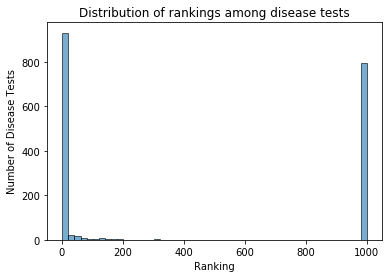

In [70]:
#histogram of rankings for orphanet disease data (each disease run once)
plt.hist(compiled_ranks, bins=50, alpha = 0.6, ec = "black")
plt.xlabel("Ranking")
plt.ylabel("Number of Disease Tests")
plt.title("Distribution of rankings among disease tests")
plt.show()

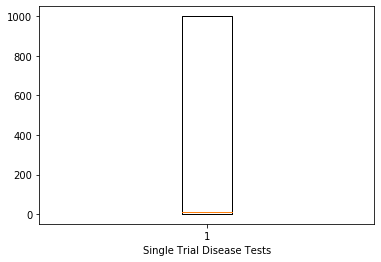

In [73]:
plt.boxplot(compiled_ranks)
plt.xlabel("Single Trial Disease Tests")
plt.show()